<a href="https://colab.research.google.com/github/componavt/LLLE-R1900s/blob/main/src/visualization/percent_stacked_bar_by_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Percent Stacked Bar by Credits

This notebook visualizes **loan amount trends over time**, broken down by:
- **Settlements** (villages, volosts, etc.)
- **Credit types** (e.g., FarmBuildings, Livestock, Housing)

✨ **Key visualizations:**
- 📊 **Percent Stacked Bar by Credits**:  
  Shows the **annual share (%) of selected credit types** (configured via `SELECTED_CREDIT_ITEMS`) **plus an "Other" category** that aggregates all remaining types.  
  Percentages are calculated **relative to the total annual loan amount** (all categories).  
  Each segment displays: **absolute sum in rubles** and **percentage share**.
- 🏘️ **Loan Amounts Over Time by Settlement**
- 🏷️ **Loan Amounts Over Time by Credit Type**

🎨 **Fully configurable:**
- 🌍 **Language**: Russian (`ru`) or English (`en`) via `USE_LANGUAGE`
- 🎯 **Credit types**: select specific categories via `SELECTED_CREDIT_ITEMS` (values from `Name` column in `credit_items.csv`)
- 🖼️ All plots saved as high-quality PNGs in `outputs/`

✅ Bilingual labels, robust validation, and expert-friendly output.

[2] 📦 🛠️ Install & Configure

In [1]:
# Install required packages
!pip install -q python-dotenv pandas matplotlib

# Clone the repo if running in Colab (optional)
import os

if not os.path.exists('LLLE-R1900s'):
    !git clone https://github.com/componavt/LLLE-R1900s.git
    %cd LLLE-R1900s
else:
    %cd LLLE-R1900s


# === LANGUAGE SWITCH ===
USE_LANGUAGE = "ru"  # ← Change to "en" for English
assert USE_LANGUAGE in ("ru", "en"), "USE_LANGUAGE must be 'ru' or 'en'"

# === VISUALIZATION THRESHOLD (no longer used, but kept for reference) ===
MIN_CREDIT_VISUAL = 3.0  # ← минимальная доля (в %), чтобы credit_item отображался за год
assert 0 <= MIN_CREDIT_VISUAL <= 100, "MIN_CREDIT_VISUAL must be between 0 and 100"

# === SELECT CREDIT TYPES TO VISUALIZE ===
SELECTED_CREDIT_ITEMS = ["Migration", "CraftMaterials", "CraftTools"]
# Note: values must match 'Name' column in credit_items.csv

Cloning into 'LLLE-R1900s'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 649 (delta 39), reused 5 (delta 1), pack-reused 583 (from 1)
Receiving objects: 100% (649/649), 5.21 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (476/476), done.
/content/LLLE-R1900s


[3] 📥 Load and Prepare Data

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Validate SELECTED_CREDIT_ITEMS early
valid_names = set(pd.read_csv('data/credit_items.csv')['Name'])
invalid = set(SELECTED_CREDIT_ITEMS) - valid_names
if invalid:
    raise ValueError(f"Invalid credit item(s): {invalid}. Must be from 'Name' column in credit_items.csv.")

# Load config
load_dotenv('config.env')

# Paths
csv_out_dir = os.getenv('CSV_OUT_DIR', 'data/csv_out')
output_file_name = os.getenv('OUTPUT_CSV_FILE')

if not output_file_name:
    csv_files = [f for f in os.listdir(csv_out_dir) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the output directory.")
    output_file_name = csv_files[0]

csv_path = os.path.join(csv_out_dir, output_file_name)
print(f"Loading loan data from: {csv_path}")

# Load main data
df_loans = pd.read_csv(csv_path)
print(f"Loaded {len(df_loans)} loan records.")

# Load reference data
df_credit = pd.read_csv('data/credit_items.csv')
df_society = pd.read_csv('data/society_settlement.csv')

# --- Settlement display names ---
if USE_LANGUAGE == "ru":
    df_society['display_settlement'] = df_society['Russian']
else:
    df_society['display_settlement'] = df_society['English']

settlement_name_map = dict(zip(df_society['English'], df_society['display_settlement']))

# Validate settlements
unknown_settlements = set(df_loans['settlement']) - set(df_society['English'])
if unknown_settlements:
    print("⚠️ Warning: Unknown settlements in loan ", unknown_settlements)

# Add display names
df_loans['display_settlement'] = df_loans['settlement'].map(settlement_name_map)
df_loans = df_loans.dropna(subset=['display_settlement'])

# --- Credit item display labels ---
if USE_LANGUAGE == "ru":
    df_credit['display_label'] = df_credit['loan_short_ru']
else:
    df_credit['display_label'] = df_credit['Name']

credit_label_map = dict(zip(df_credit['Name'], df_credit['display_label']))

# Add "Other" label
other_label = "Other" if USE_LANGUAGE == "en" else "Прочие"
credit_label_map["Other"] = other_label

# Validate credit items
unknown_items = set(df_loans['credit_item']) - set(df_credit['Name'])
if unknown_items:
    print("⚠️ Warning: Unknown credit_item values:", unknown_items)

# --- Prepare time axis ---
df_loans['mid_month'] = ((df_loans['month_start'] + df_loans['month_end']) // 2).astype(int)
df_loans['date'] = pd.to_datetime(
    df_loans['year'].astype(str) + '-' + df_loans['mid_month'].astype(str) + '-01'
)

# Ensure output dir
os.makedirs('outputs', exist_ok=True)

print("✅ Data loaded and enriched with bilingual labels.")

Loading loan data from: data/csv_out/loans_s28_i21.csv
Loaded 1768 loan records.
✅ Data loaded and enriched with bilingual labels.


[4] 📊 Percentage Component Bar Chart by Year and Credit Type (Main + Minor with Threshold — Shares of Total Annual Volume)

🔍 Yearly credit type shares (for threshold tuning):

--- 1911 ---
  Расх. на жильё: 1,587 руб. (38.96%)
  Корм для скота: 1,038 руб. (25.48%)
  Ремесленные инструменты: 538 руб. (13.21%)
  Приобр-е скота: 419 руб. (10.29%)
  Личные расходы: 181 руб. (4.44%)
  С/х постройки: 172 руб. (4.22%)
  Торговля: 108 руб. (2.65%)
  Орудия труда: 20 руб. (0.49%)
  С/х семена: 10 руб. (0.25%)

--- 1912 ---
  Торговля: 8,447 руб. (25.77%)
  Расх. на жильё: 5,051 руб. (15.41%)
  Приобр-е скота: 4,929 руб. (15.04%)
  Личные расходы: 3,797 руб. (11.59%)
  С/х семена: 3,131 руб. (9.55%)
  Ремесленные инструменты: 1,773 руб. (5.41%)
  С/х постройки: 1,672 руб. (5.10%)
  Орудия труда: 1,056 руб. (3.22%)
  Временный заработок: 768 руб. (2.34%)
  Корм для скота: 758 руб. (2.31%)
  Наём раб. силы: 607 руб. (1.85%)
  Частные долги: 596 руб. (1.82%)
  Ремесленные материалы: 120 руб. (0.37%)
  Улучш-е земель: 40 руб. (0.12%)
  Аренда имущества: 30 руб. (0.09%)

--- 1913 ---
  Приобр-е скота: 7,611 руб. (31.17%)

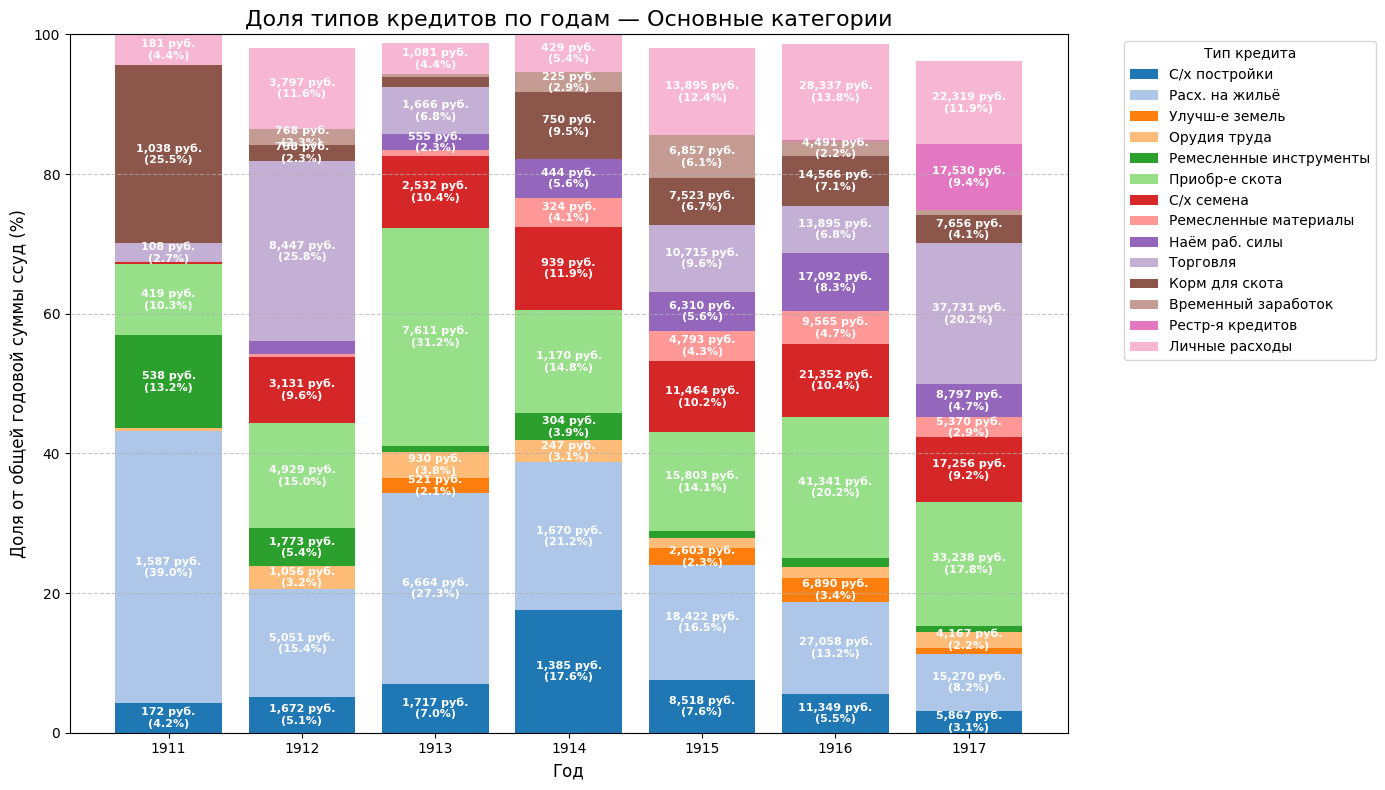

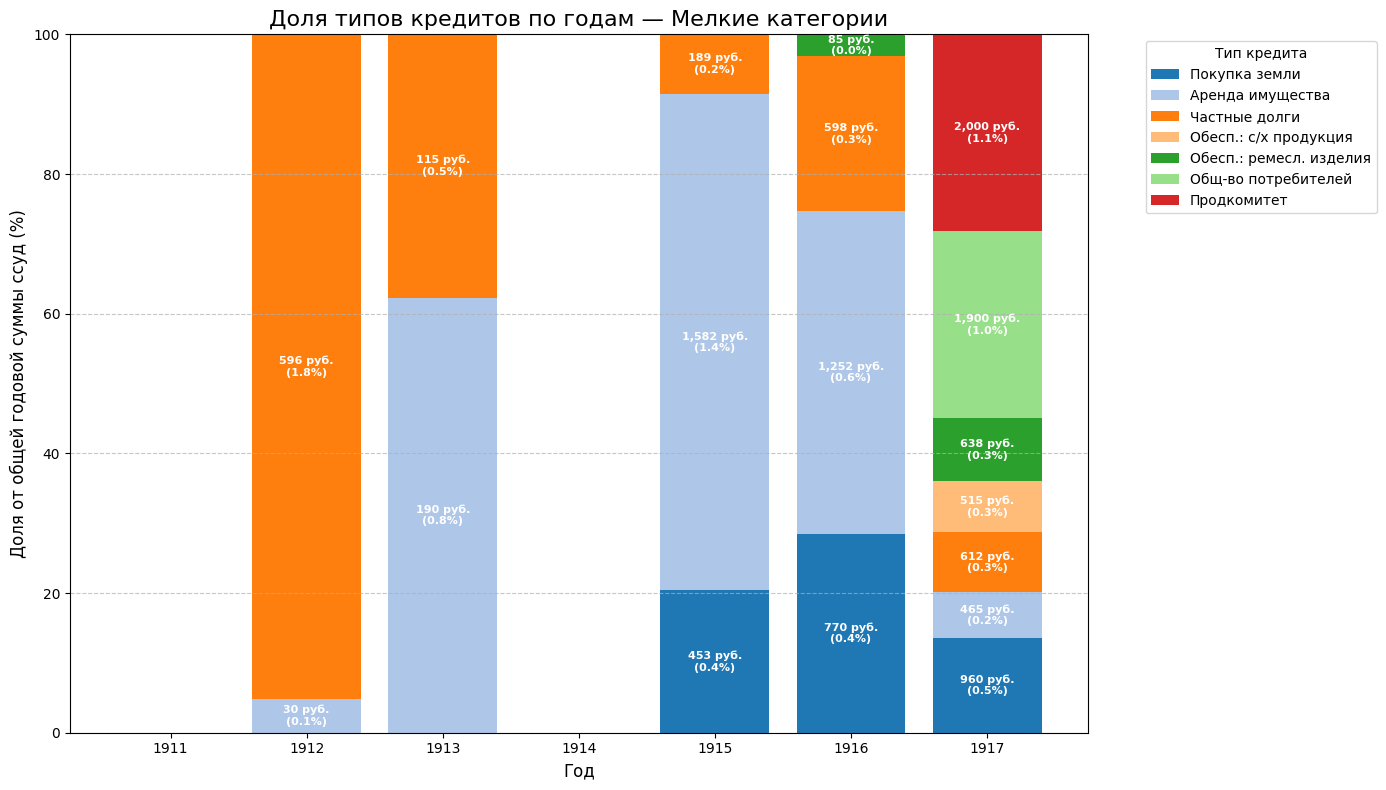


✅ Two charts saved: 'main' (≥3.0%) and 'minor' (<3.0%).
ℹ️  Both charts show percentages relative to total annual loan amount.
ℹ️  Minor chart is visually stretched to 100% for readability, but labels reflect true shares.


In [3]:
# === CONFIGURATION (should be defined earlier) ===
# MIN_CREDIT_VISUAL — threshold in percent (e.g., 3.0)
# USE_LANGUAGE — "ru" or "en"

import numpy as np

# --- 1. Prepare data ---
# Aggregate by year and credit_item
df_yearly = df_loans.groupby(['year', 'credit_item'])['amount_rubles'].sum().reset_index()
df_pivot = df_yearly.pivot(index='year', columns='credit_item', values='amount_rubles').fillna(0)
df_pivot['total'] = df_pivot.sum(axis=1)

# Percentages relative to total annual amount (all categories)
df_pct_total = df_pivot.drop(columns=['total']).div(df_pivot['total'], axis=0) * 100
df_abs = df_pivot.drop(columns=['total'])  # absolute ruble amounts

# --- 2. Print detailed breakdown for expert review ---
print("🔍 Yearly credit type shares (for threshold tuning):")
for year in sorted(df_pct_total.index):
    print(f"\n--- {year} ---")
    yearly_data = df_pct_total.loc[year].sort_values(ascending=False)
    for credit_item, pct in yearly_data.items():
        if pct > 0:
            display_name = credit_label_map.get(credit_item, credit_item)
            abs_val = df_abs.loc[year, credit_item]
            print(f"  {display_name}: {abs_val:,.0f} руб. ({pct:.2f}%)")
print(f"\n📊 Using threshold: MIN_CREDIT_VISUAL = {MIN_CREDIT_VISUAL}%")

# --- 3. Split categories ---
categories_over_threshold = set()
categories_under_threshold = set(df_pct_total.columns)

for credit_item in df_pct_total.columns:
    if (df_pct_total[credit_item] >= MIN_CREDIT_VISUAL).any():
        categories_over_threshold.add(credit_item)

categories_under_threshold = categories_under_threshold - categories_over_threshold

# --- 4. Plotting function ---
def plot_credit_share_consistent(df_abs_input, df_pct_total_input, credit_columns, title_suffix, filename_suffix, stretch_to_100=False):
    """
    Plot stacked bar chart where:
    - Heights represent either true percentages (stretch_to_100=False)
      or visually stretched to 100% (stretch_to_100=True).
    - Labels always show true percentages relative to total annual amount.
    """
    if not credit_columns:
        print(f"⚠️ No categories to plot for {title_suffix}. Skipping.")
        return

    # Select columns in consistent order
    ordered_cols = [col for col in df_credit['Name'] if col in credit_columns]
    df_abs_sel = df_abs_input[ordered_cols]
    df_pct_sel = df_pct_total_input[ordered_cols]  # true percentages

    years = df_abs_sel.index
    fig, ax = plt.subplots(figsize=(14, 8))

    # Colors
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i % 20) for i in range(len(ordered_cols))]

    if stretch_to_100:
        # Visually stretch to 100%: normalize only the selected categories
        row_sums = df_abs_sel.sum(axis=1)
        # Avoid division by zero
        row_sums = row_sums.replace(0, 1)
        df_visual_pct = df_abs_sel.div(row_sums, axis=0) * 100
    else:
        # Use true percentages (will sum to <=100%)
        df_visual_pct = df_pct_sel.copy()

    bottom = np.zeros(len(years))

    for idx, col in enumerate(ordered_cols):
        abs_vals = df_abs_sel[col].values
        true_pct_vals = df_pct_sel[col].values  # for labels
        visual_heights = df_visual_pct[col].values  # for bar height

        # Plot bar segment
        ax.bar(years, visual_heights, bottom=bottom, label=credit_label_map.get(col, col), color=colors[idx])

        # Add label in the center of the segment (if visually tall enough)
        for i, (year, height, abs_val, true_pct) in enumerate(zip(years, visual_heights, abs_vals, true_pct_vals)):
            if height > 2:  # only if visually large enough to fit text
                y_pos = bottom[i] + height / 2
                text = f"{abs_val:,.0f} руб.\n({true_pct:.1f}%)"
                ax.text(year, y_pos, text, ha='center', va='center', fontsize=8, color='white', fontweight='bold')

        bottom += visual_heights

    # Chart styling
    title = f"Share of Credit Types by Year — {title_suffix}" if USE_LANGUAGE == "en" else f"Доля типов кредитов по годам — {title_suffix}"
    xlabel = "Year" if USE_LANGUAGE == "en" else "Год"
    ylabel = "Percentage of Total Annual Loan Amount (%)" if USE_LANGUAGE == "en" else "Доля от общей годовой суммы ссуд (%)"

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=0)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Legend: only displayed categories
    legend_labels = [credit_label_map.get(col, col) for col in ordered_cols]
    ax.legend(legend_labels, title="Credit Type" if USE_LANGUAGE == "en" else "Тип кредита",
              bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(f'outputs/credit_share_by_year_{filename_suffix}.png', dpi=150)
    plt.show()

# --- 5. Plot both charts ---

# Main categories: show true percentages (sum <= 100%)
plot_credit_share_consistent(
    df_abs_input=df_abs,
    df_pct_total_input=df_pct_total,
    credit_columns=categories_over_threshold,
    title_suffix="Main Categories" if USE_LANGUAGE == "en" else "Основные категории",
    filename_suffix="main",
    stretch_to_100=False
)

# Minor categories: visually stretched to 100% for readability, but labels show true % of total
plot_credit_share_consistent(
    df_abs_input=df_abs,
    df_pct_total_input=df_pct_total,
    credit_columns=categories_under_threshold,
    title_suffix="Minor Categories" if USE_LANGUAGE == "en" else "Мелкие категории",
    filename_suffix="minor",
    stretch_to_100=True
)

print(f"\n✅ Two charts saved: 'main' (≥{MIN_CREDIT_VISUAL}%) and 'minor' (<{MIN_CREDIT_VISUAL}%).")
print("ℹ️  Both charts show percentages relative to total annual loan amount.")
print("ℹ️  Minor chart is visually stretched to 100% for readability, but labels reflect true shares.")

### 📊 Доля типов кредитов по годам: основные и мелкие категории (описание для графиков выше)

Эти два графика показывают **структуру ссуд по типам кредитов** за каждый год, выраженную в **процентах от общей годовой суммы всех ссуд** (включая все категории — и крупные, и мелкие).

#### 📌 Первый график: **Основные категории**  
- Отображаются только те типы кредитов, **доля которых ≥ `MIN_CREDIT_VISUAL`%** (например, ≥ 3%) **хотя бы в один год**.  
- Высота каждого столбца **не обязательно равна 100%** — она отражает **суммарную долю только отображаемых категорий**.  
- Если столбец «не доходит» до 100%, значит, оставшаяся часть приходится на мелкие категории (см. второй график).  
- В центре каждого сегмента указаны:  
  **абсолютная сумма в рублях** и **истинная доля от общего годового объёма** (в %).

#### 🔍 Второй график: **Мелкие категории**  
- Отображаются **все типы кредитов, доля которых < `MIN_CREDIT_VISUAL`% во все годы**.  
- Для лучшей читаемости столбцы **визуально растянуты до 100%**, но **подписи показывают истинные доли** от общего годового объёма (например, `0.8%`).  
- Это позволяет увидеть даже очень небольшие ссуды, не теряя масштаба сравнения с первым графиком.

#### 💡 Зачем так сделано?
- Оба графика используют **единый базис** — **общую сумму ссуд за год**.  
- Это даёт возможность **точно сравнивать** доли между «основными» и «мелкими» категориями.  
- Эксперт может оценить, насколько значимы мелкие направления и не «теряются» ли они в агрегированных данных.

> 📝 Порог `MIN_CREDIT_VISUAL` задаётся в начале ноутбука и может быть изменён для настройки детализации.

[6] 📊 Percentage Component Bar Chart: Selected Types + "Other"

🔍 Summary per year:
  1911: 538 руб. (13.21%), 9 ссуд (5.45%)
  1912: 2,661 руб. (8.12%), 102 ссуд (8.17%)
  1913: 505 руб. (2.07%), 22 ссуд (2.41%)
  1914: 853 руб. (10.82%), 41 ссуд (11.82%)
  1915: 12,765 руб. (11.40%), 327 ссуд (8.33%)
  1916: 16,825 руб. (8.21%), 453 ссуд (8.42%)
  1917: 8,436 руб. (4.51%), 211 ссуд (8.12%)


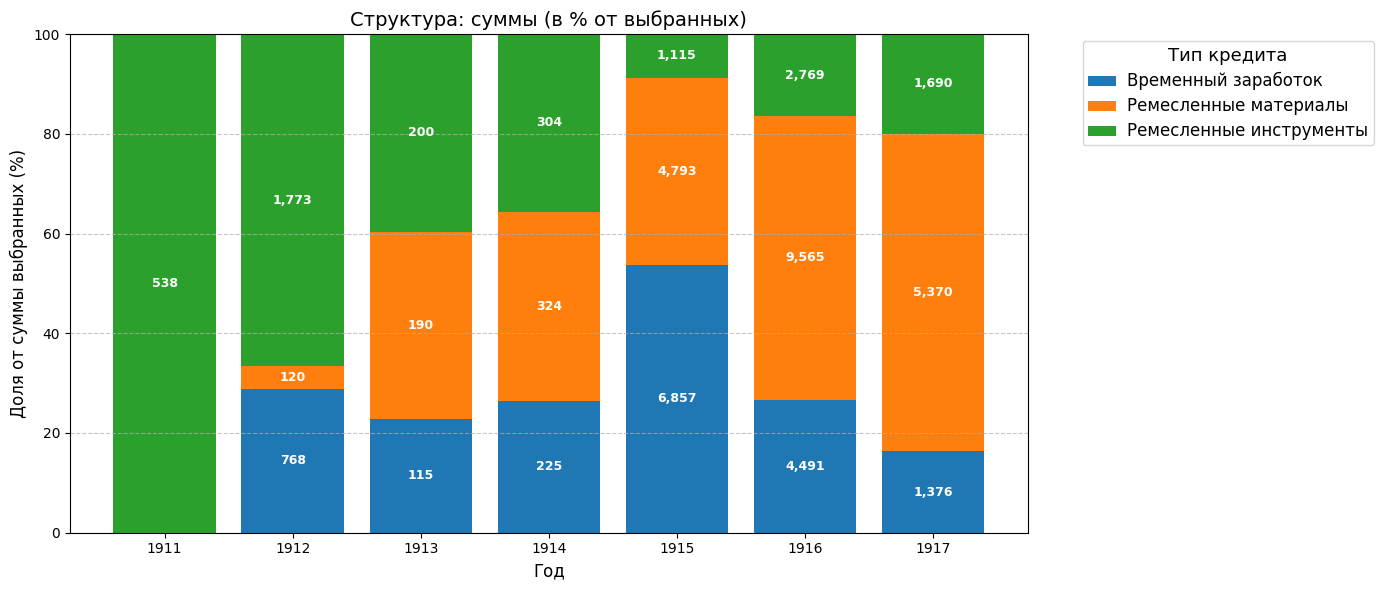

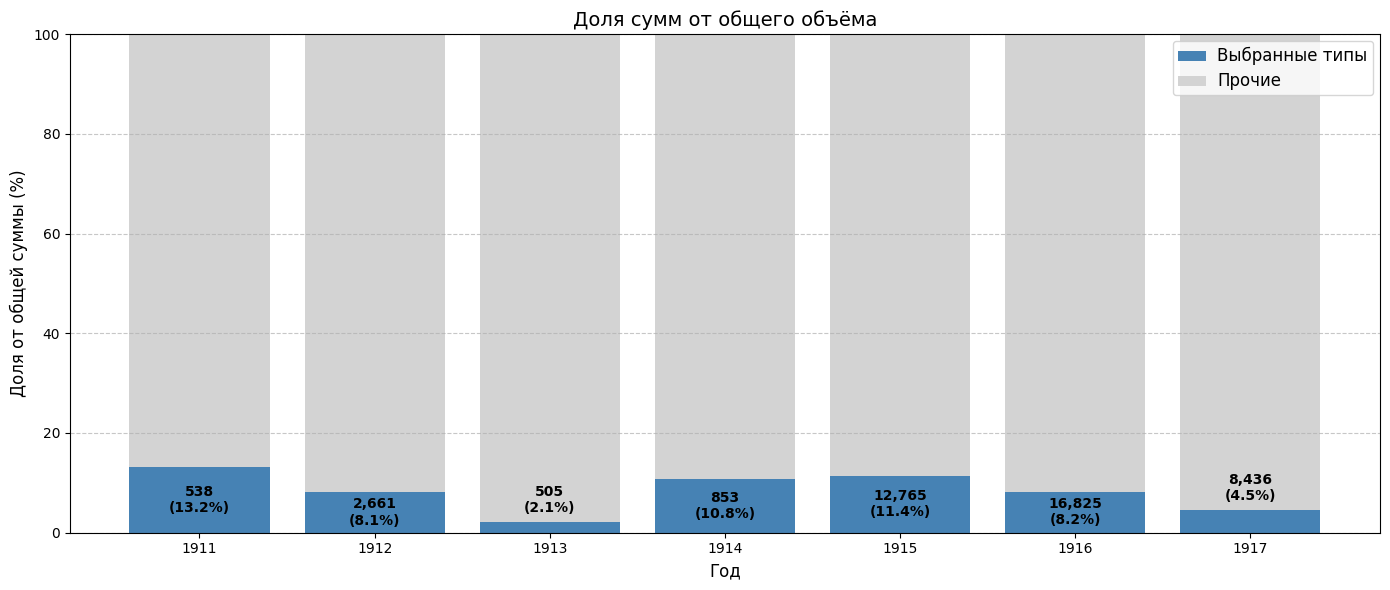

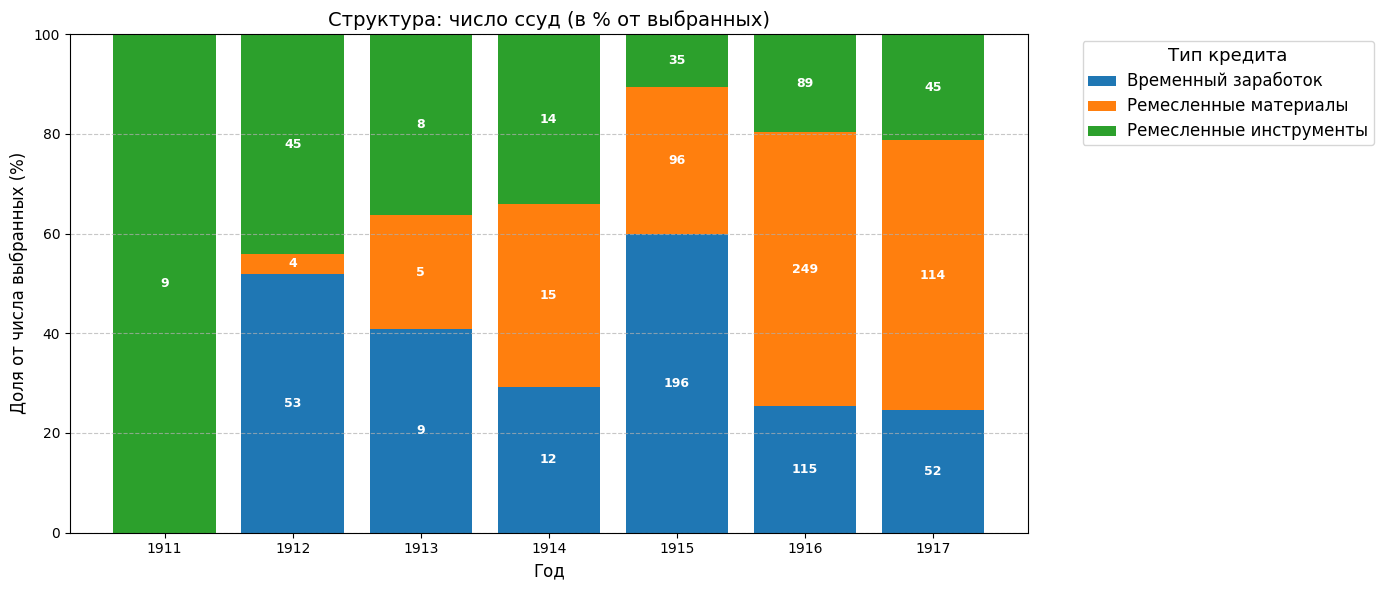

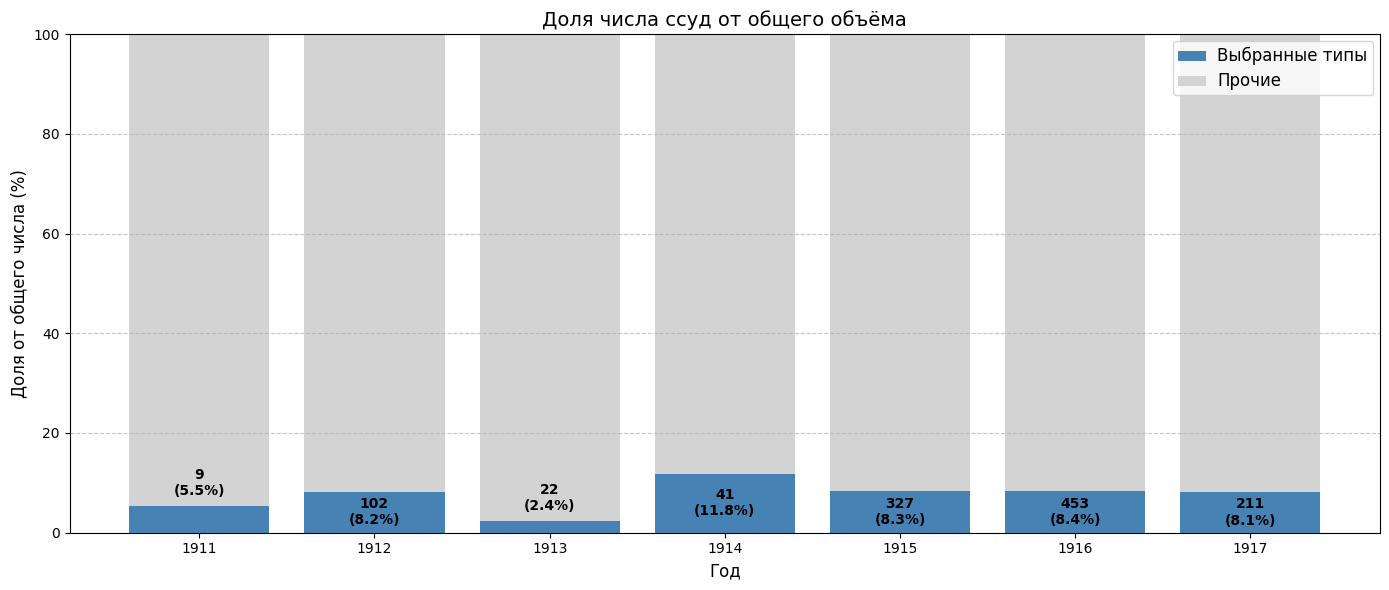


✅ All four charts saved to 'outputs/' folder:
  • selected_types_internal_amounts.png
  • selected_vs_other_total_amounts.png
  • selected_types_internal_counts.png
  • selected_vs_other_total_counts.png


In [4]:
# [6] 📊 Four-Panel Analysis: Amounts & Loan Counts (Internal + Total Share)

import numpy as np

# --- 1. Aggregate by year and credit_item (amounts and counts) ---
df_yearly_amount = df_loans.groupby(['year', 'credit_item'])['amount_rubles'].sum().reset_index()
df_yearly_count = df_loans.groupby(['year', 'credit_item'])['loan_count'].sum().reset_index()

# Pivot to wide format
df_pivot_amount = df_yearly_amount.pivot(index='year', columns='credit_item', values='amount_rubles').fillna(0)
df_pivot_count = df_yearly_count.pivot(index='year', columns='credit_item', values='loan_count').fillna(0)

# Total per year (all categories)
total_amount_all = df_pivot_amount.sum(axis=1)
total_count_all = df_pivot_count.sum(axis=1)

# --- 2. Prepare selected and "Other" totals ---
selected_set = set(SELECTED_CREDIT_ITEMS)
all_columns = set(df_pivot_amount.columns)
other_columns = all_columns - selected_set

# Selected totals
selected_amount = df_pivot_amount[list(selected_set)].sum(axis=1) if selected_set else pd.Series(0, index=df_pivot_amount.index)
selected_count = df_pivot_count[list(selected_set)].sum(axis=1) if selected_set else pd.Series(0, index=df_pivot_count.index)

# Percentages of total
selected_amount_pct = (selected_amount / total_amount_all) * 100
selected_count_pct = (selected_count / total_count_all) * 100

# --- 3. Print summary ---
print("🔍 Summary per year:")
for year in sorted(df_pivot_amount.index):
    amt = selected_amount.loc[year]
    cnt = int(selected_count.loc[year])
    amt_pct = selected_amount_pct.loc[year]
    cnt_pct = selected_count_pct.loc[year]
    print(f"  {year}: {amt:,.0f} руб. ({amt_pct:.2f}%), {cnt} ссуд ({cnt_pct:.2f}%)")

# --- 4. Helper: plot with adaptive label placement ---
def add_labels(ax, years, heights, bottom, values, percentages, threshold=8):
    """Add labels inside or above bars based on height."""
    for i, (year, height, val, pct) in enumerate(zip(years, heights, values, percentages)):
        if height >= threshold:
            # Inside
            y_pos = bottom[i] + height / 2
            va = 'center'
        else:
            # Above
            y_pos = bottom[i] + height + 1.5  # small offset
            va = 'bottom'
        text = f"{val:,.0f}\n({pct:.1f}%)"
        ax.text(year, y_pos, text, ha='center', va=va, fontsize=10, color='black', fontweight='bold')

# --- 5. PLOT 1: Internal structure — Amounts (normalized to selected total) ---
if selected_set:
    df_sel_amt = df_pivot_amount[list(SELECTED_CREDIT_ITEMS)].copy()
    totals = df_sel_amt.sum(axis=1).replace(0, 1)
    df_sel_amt_pct = df_sel_amt.div(totals, axis=0) * 100

    years = df_sel_amt.index
    fig, ax = plt.subplots(figsize=(14, 6))

    cmap = plt.get_cmap('tab10')
    colors = [cmap(i % 10) for i in range(len(SELECTED_CREDIT_ITEMS))]

    bottom = np.zeros(len(years))
    for idx, col in enumerate(SELECTED_CREDIT_ITEMS):
        pct_vals = df_sel_amt_pct[col].values
        abs_vals = df_sel_amt[col].values
        ax.bar(years, pct_vals, bottom=bottom, label=credit_label_map[col], color=colors[idx])
        for i, (year, height, abs_val) in enumerate(zip(years, pct_vals, abs_vals)):
            if height > 3:
                y_pos = bottom[i] + height / 2
                ax.text(year, y_pos, f"{abs_val:,.0f}", ha='center', va='center', fontsize=9, color='white', fontweight='bold')
        bottom += pct_vals

    title = "Internal Structure: Amounts (Normalized to Selected Total)" if USE_LANGUAGE == "en" else "Структура: суммы (в % от выбранных)"
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Year" if USE_LANGUAGE == "en" else "Год", fontsize=12)
    ax.set_ylabel("Percentage of Selected Amounts (%)" if USE_LANGUAGE == "en" else "Доля от суммы выбранных (%)", fontsize=12)
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=0)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    legend = ax.legend(title="Credit Type" if USE_LANGUAGE == "en" else "Тип кредита",
                       bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.setp(legend.get_texts(), fontsize=12)      # 1.5–2× base (base=8–10)
    plt.setp(legend.get_title(), fontsize=13)

    plt.tight_layout()
    plt.savefig('outputs/selected_types_internal_amounts.png', dpi=150)
    plt.show()
else:
    print("⚠️ No selected credit items. Skipping internal amount plot.")

# --- 6. PLOT 2: Total share — Amounts (of all loans) ---
fig, ax = plt.subplots(figsize=(14, 6))

years = df_pivot_amount.index
heights = selected_amount_pct.values
bottoms = np.zeros_like(heights)

ax.bar(years, heights, label=("Selected Types" if USE_LANGUAGE == "en" else "Выбранные типы"), color='steelblue')
ax.bar(years, 100 - heights, bottom=heights, label=("Other" if USE_LANGUAGE == "en" else "Прочие"), color='lightgray')

# Add labels with adaptive placement
add_labels(ax, years, heights, bottoms, selected_amount.values, selected_amount_pct.values, threshold=8)

title = "Total Share: Amounts (of All Loans)" if USE_LANGUAGE == "en" else "Доля сумм от общего объёма"
ax.set_title(title, fontsize=14)
ax.set_xlabel("Year" if USE_LANGUAGE == "en" else "Год", fontsize=12)
ax.set_ylabel("Percentage of Total Annual Amount (%)" if USE_LANGUAGE == "en" else "Доля от общей суммы (%)", fontsize=12)
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.7)
legend = ax.legend(loc='upper right')
plt.setp(legend.get_texts(), fontsize=12)
plt.setp(legend.get_title(), fontsize=13)

plt.tight_layout()
plt.savefig('outputs/selected_vs_other_total_amounts.png', dpi=150)
plt.show()

# --- 7. PLOT 3: Internal structure — Loan Counts (normalized to selected total) ---
if selected_set:
    df_sel_cnt = df_pivot_count[list(SELECTED_CREDIT_ITEMS)].copy()
    totals = df_sel_cnt.sum(axis=1).replace(0, 1)
    df_sel_cnt_pct = df_sel_cnt.div(totals, axis=0) * 100

    years = df_sel_cnt.index
    fig, ax = plt.subplots(figsize=(14, 6))

    cmap = plt.get_cmap('tab10')
    colors = [cmap(i % 10) for i in range(len(SELECTED_CREDIT_ITEMS))]

    bottom = np.zeros(len(years))
    for idx, col in enumerate(SELECTED_CREDIT_ITEMS):
        pct_vals = df_sel_cnt_pct[col].values
        abs_vals = df_sel_cnt[col].values.astype(int)
        ax.bar(years, pct_vals, bottom=bottom, label=credit_label_map[col], color=colors[idx])
        for i, (year, height, abs_val) in enumerate(zip(years, pct_vals, abs_vals)):
            if height > 3:
                y_pos = bottom[i] + height / 2
                ax.text(year, y_pos, f"{abs_val}", ha='center', va='center', fontsize=9, color='white', fontweight='bold')
        bottom += pct_vals

    title = "Internal Structure: Loan Counts (Normalized to Selected Total)" if USE_LANGUAGE == "en" else "Структура: число ссуд (в % от выбранных)"
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Year" if USE_LANGUAGE == "en" else "Год", fontsize=12)
    ax.set_ylabel("Percentage of Selected Counts (%)" if USE_LANGUAGE == "en" else "Доля от числа выбранных (%)", fontsize=12)
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=0)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    legend = ax.legend(title="Credit Type" if USE_LANGUAGE == "en" else "Тип кредита",
                       bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.setp(legend.get_texts(), fontsize=12)
    plt.setp(legend.get_title(), fontsize=13)

    plt.tight_layout()
    plt.savefig('outputs/selected_types_internal_counts.png', dpi=150)
    plt.show()
else:
    print("⚠️ No selected credit items. Skipping internal count plot.")

# --- 8. PLOT 4: Total share — Loan Counts (of all loans) ---
fig, ax = plt.subplots(figsize=(14, 6))

years = df_pivot_count.index
heights = selected_count_pct.values
bottoms = np.zeros_like(heights)

ax.bar(years, heights, label=("Selected Types" if USE_LANGUAGE == "en" else "Выбранные типы"), color='steelblue')
ax.bar(years, 100 - heights, bottom=heights, label=("Other" if USE_LANGUAGE == "en" else "Прочие"), color='lightgray')

# Add labels with adaptive placement
add_labels(ax, years, heights, bottoms, selected_count.values.astype(int), selected_count_pct.values, threshold=8)

title = "Total Share: Loan Counts (of All Loans)" if USE_LANGUAGE == "en" else "Доля числа ссуд от общего объёма"
ax.set_title(title, fontsize=14)
ax.set_xlabel("Year" if USE_LANGUAGE == "en" else "Год", fontsize=12)
ax.set_ylabel("Percentage of Total Annual Count (%)" if USE_LANGUAGE == "en" else "Доля от общего числа (%)", fontsize=12)
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.7)
legend = ax.legend(loc='upper right')
plt.setp(legend.get_texts(), fontsize=12)
plt.setp(legend.get_title(), fontsize=13)

plt.tight_layout()
plt.savefig('outputs/selected_vs_other_total_counts.png', dpi=150)
plt.show()

print(f"\n✅ All four charts saved to 'outputs/' folder:")
print("  • selected_types_internal_amounts.png")
print("  • selected_vs_other_total_amounts.png")
print("  • selected_types_internal_counts.png")
print("  • selected_vs_other_total_counts.png")

### 📈 Four Charts for Analysis of Selected Credit Types

1. **Internal structure by amount** — how rubles are distributed among the 3 types (% of their total amount).  
2. **Total share by amount** — blue: selected types, gray: all others (% of all loans).  
3. **Internal structure by loan count** — how loans are distributed among the 3 types.  
4. **Total share by loan count** — share of selected loans out of the total number.

Colors: 🔵 blue = selected types, ⬜ gray = everything else.

---

### 📈 Четыре графика для анализа выбранных типов ссуд

1. **Внутренняя структура по суммам** — как распределяются рубли между 3 типами (в % от их общей суммы).  
2. **Общая доля по суммам** — синий: выбранные типы, серый: прочие (в % от всех ссуд).  
3. **Внутренняя структура по числу ссуд** — как распределяются ссуды между 3 типами.  
4. **Общая доля по числу ссуд** — доля выбранных ссуд от общего количества.

Цвета: 🔵 синий = интересующие типы, ⬜ серый = всё остальное.